In [1]:
import tensorflow as tf
import numpy as np

import pandas as pd

import time

import matplotlib.pyplot as plt

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

3 Physical GPUs, 1 Logical GPUs


In [3]:
BATCH_SIZE = 32
IMG_H, IMG_W = 224, 224
BUFFER_SIZE = 3000

## 設定路徑

In [4]:
PATH_TO_DATA = "../Comp4/task4/data/"
PATH_CKPTS = "../Comp4/task4/ckpts/11_encoder_128/"

checkpoint_name = "11_encoder_128"

In [5]:
MARGIN_C = 1.2
LEARNING_RATE = 1e-4
EPOCHS = 180

CV_every = 5
SAVE_every = 5

In [6]:
aug_p = 0.9

up_down_flip_p = 0.25
left_right_flip_p = 0.5
rot_p = 0.5

In [7]:
def impute_answer(text):
    assert len(text) <= 9
    
    if len(text) == 9:
        return text
    
    need_char = 9 - len(text)
    return ("0" * need_char) + text

def get_q_a(folder, is_get_answer):
    tr_q = np.genfromtxt(PATH_TO_DATA + folder + "q.csv", delimiter=',').astype(np.int32).astype(str)

    tr_target = tr_q[:,0]
    tr_target = np.expand_dims(tr_target, 1)
    tr_target = np.repeat(tr_target, 9, axis=1)

    tr_candidate = tr_q[:,1:]

    if is_get_answer:
        tr_a = np.genfromtxt(PATH_TO_DATA + folder + "a.csv", delimiter=',').astype(np.int32).astype(str)    
        ans = []
        for i in range(tr_a.shape[0]):
            ans.append(list(impute_answer(tr_a[i, 1])))

        ans = np.asarray(ans).astype(np.int32)
        
        return tr_target, tr_candidate, ans
    else:
        return tr_target, tr_candidate

In [8]:
@tf.function
def image_preprocess(folder, img_name):
    img = tf.io.read_file(PATH_TO_DATA + folder + img_name + ".png")
    img = tf.image.decode_image(img, channels=3)
    img.set_shape([IMG_H, IMG_W, 3])
    img = tf.cast(img, tf.float32)
    
    img = tf.image.rgb_to_grayscale(img)
    
    img = tf.image.resize(img, size=[64, 64])
    
    img = img / 255
    
    return img

In [9]:
@tf.function
def random_flip(image):
    up_down_outcome = tf.random.uniform([1], 0, 1)
    right_left_outcome = tf.random.uniform([1], 0, 1)

    if up_down_outcome<up_down_flip_p:
        image = tf.image.flip_up_down(image)

    if right_left_outcome<left_right_flip_p:
        image = tf.image.flip_left_right(image)

    return image

@tf.function
def random_rot90(image):
    prob = tf.random.uniform([1],0,1)
    
    if prob < (rot_p/2):
        image = tf.image.rot90(image)
    elif (prob >= (rot_p/2)) and (prob < rot_p):
        image = tf.image.rot90(image, k=2)   
        
    return image

@tf.function
def image_augmentation(img):
    aug_sample = tf.random.uniform([1],0,1)
    
    if aug_sample < aug_p:
        img = random_flip(img)
        img = random_rot90(img)
    
    return img

In [10]:
tr_target, tr_candidate, tr_ans = get_q_a("s4_train/", is_get_answer=True)
val_target, val_candidate, val_ans = get_q_a("s4_valid/", is_get_answer=True)
te_target, te_candidate = get_q_a("s4_test/", is_get_answer=False)

# Dataset

In [11]:
class ds_train_generator(object):
    def __init__(self, target, candidate, answer, ds_folder):
        self.target = target[:, 0]
        self.candidate = candidate
        self.answer = answer
        self.ds_folder = ds_folder
        
    def preprocessing(self, target, candidate, answer):
        img_target = image_preprocess(self.ds_folder, target)
        
        qq = tf.random.uniform((), 0, 9)
        sample_idx = tf.cast(qq, tf.int32)
        sampled_candidate = tf.gather(candidate, sample_idx, axis=0)
        sampled_answer = tf.gather(answer, sample_idx, axis=0)
        
        img_candidate = image_preprocess(self.ds_folder, sampled_candidate)
        answer = tf.cast(sampled_answer, tf.float32)
        
        img_target = image_augmentation(img_target)
        img_candidate = image_augmentation(img_candidate)
        
        return img_target, img_candidate, answer
        
    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.target,
                                                      self.candidate,
                                                      self.answer))
        dataset = dataset.map(self.preprocessing, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
        dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        
        return dataset

In [12]:
class ds_test_generator(object):
    def __init__(self, target, candidate, ds_folder):
        self.target = target.flatten()
        self.candidate = candidate.flatten()
        self.ds_folder = ds_folder
        
    def preprocessing(self, target, candidate):
        img_target = image_preprocess(self.ds_folder, target)
        img_candidate = image_preprocess(self.ds_folder, candidate)
        
        return img_target, img_candidate
        
    def generate(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.target, self.candidate))
        dataset = dataset.map(self.preprocessing, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        dataset = dataset.batch(BATCH_SIZE)
        dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
        
        return dataset

In [13]:
ds_train_gen = ds_train_generator(tr_target, tr_candidate, tr_ans, "s4_train_image/")
ds_train = ds_train_gen.generate()

In [14]:
ds_valid_gen = ds_test_generator(val_target, val_candidate, "s4_valid_image/")
ds_valid = ds_valid_gen.generate()

ds_test_gen = ds_test_generator(te_target, te_candidate, "s4_test_image/")
ds_test = ds_test_gen.generate()

# Model and Loss

In [16]:
class siamese_net(tf.keras.Model):
    def __init__(self):
        super(siamese_net, self).__init__()
        self.df_dim = 128
        self.t_dim = 128
        
        self.net_h0_conv2d = tf.keras.layers.Conv2D(self.df_dim, 4, 2, padding='SAME',use_bias=True,
                                                    kernel_initializer= tf.random_normal_initializer(stddev=0.02))
        self.net_h1_conv2d = tf.keras.layers.Conv2D(self.df_dim*2, 4, 2, padding='SAME',use_bias=True,
                                                    kernel_initializer= tf.random_normal_initializer(stddev=0.02))
        self.bn1 = tf.keras.layers.BatchNormalization()
        
        self.net_h2_conv2d = tf.keras.layers.Conv2D(self.df_dim*4, 4, 2, padding='SAME',use_bias=True,
                                                    kernel_initializer= tf.random_normal_initializer(stddev=0.02))
        self.bn2 = tf.keras.layers.BatchNormalization()
        
        self.net_h3_conv2d = tf.keras.layers.Conv2D(self.df_dim*8, 4, 2, padding='SAME',use_bias=True,
                                                    kernel_initializer= tf.random_normal_initializer(stddev=0.02))
        self.bn3 = tf.keras.layers.BatchNormalization()

        self.net_h4_flat = tf.keras.layers.Flatten()
        self.net_h4_fc = tf.keras.layers.Dense(self.t_dim, use_bias=False,
                                               kernel_initializer= tf.random_normal_initializer(stddev=0.02))

    def call(self, inputs):
        net_h0 = self.net_h0_conv2d(inputs)
        net_h0 = tf.nn.leaky_relu(net_h0)
        
        net_h1 = self.net_h1_conv2d(net_h0)
        net_h1 = self.bn1(net_h1)
        net_h1 = tf.nn.leaky_relu(net_h1)

        net_h2 = self.net_h2_conv2d(net_h1)
        net_h2 = self.bn2(net_h2)
        net_h2 = tf.nn.leaky_relu(net_h2)

        net_h3 = self.net_h3_conv2d(net_h2)
        net_h3 = self.bn3(net_h3)
        net_h3 = tf.nn.leaky_relu(net_h3)

        net_h4 = self.net_h4_flat(net_h3)
        net_h4 = self.net_h4_fc(net_h4)

        outputs = net_h4

        return outputs

In [17]:
def cosine_similarity(v1, v2):
    cost = tf.reduce_sum(tf.multiply(v1, v2), 1) / (tf.sqrt(tf.reduce_sum(tf.multiply(v1, v1), 1)) * tf.sqrt(tf.reduce_sum(tf.multiply(v2, v2), 1)))
    return cost

In [18]:
@tf.function
def contrastive_loss(target, candidate, answer):
    distance = tf.sqrt(2 - 2 * cosine_similarity(target, candidate))
    # distance = tf.sqrt(tf.reduce_sum((target - candidate)**2, 1, keepdims=True))
    similarity = answer * tf.square(distance)
    dissimilarity = (1-answer) * tf.square(tf.maximum((MARGIN_C - distance), 0))
    return tf.reduce_mean(similarity + dissimilarity)

@tf.function
def cosine_loss(target, candidate, answer):
    cosine = tf.keras.losses.cosine_similarity(target, candidate)
    output = (answer * cosine) + ((1-answer) * (cosine * (-1)))
    
    return tf.reduce_mean(output)

In [19]:
SIAMESE = siamese_net()
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

# Step

In [20]:
@tf.function
def train_step(target, candidate, answer):
    with tf.GradientTape() as tape:
        target_output = SIAMESE(target)
        candidate_output = SIAMESE(candidate)
        loss = contrastive_loss(target_output, candidate_output, answer)
        # loss = cosine_loss(target_output, candidate_output, answer)
    
    grads = tape.gradient(loss, SIAMESE.trainable_variables)
    optimizer.apply_gradients(zip(grads, SIAMESE.trainable_variables))
    
    return loss

In [21]:
@tf.function
def test_step(target, candidate):
    target_output = SIAMESE(target)
    candidate_output = SIAMESE(candidate)
    
    return cosine_similarity(target_output, candidate_output)

In [22]:
def test(dataset):
    out = []

    for t, c in dataset:
        curr = test_step(t, c)
        out.extend(curr.numpy().tolist())
        
    out = np.asarray(out)
    out = np.reshape(out, (-1,9))
    
    return out

def cut_thres(y_pred, thres):
    y_pred = (y_pred > thres).astype(np.int32)
    
    return y_pred

def convert_to_int(y):
    output = []
    y = y.astype(str).tolist()
    
    for i in range(len(y)):
        output.append(int("".join(y[i])))
        
    return output

def convert_to_output(y):
    output = []
    y = y.astype(str).tolist()
    
    for i in range(len(y)):
        output.append("".join(y[i]))
        
    return output

def cal_acc(y_true, y_pred):
    output = []
    y_true = convert_to_int(y_true)
    y_pred = convert_to_int(y_pred)
    
    for i in range(len(y_true)):
        is_same = (y_true[i] == y_pred[i])
        output.append(int(is_same))
        
    return sum(output)/len(output)

def output(pred):
    pred = convert_to_output(pred)
    
    output = pd.DataFrame({"id": range(len(pred)),
                           "Category": pred})
    
    return output

In [23]:
def validation_acc(valid_dataset, val_ans):
    try_thre = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
    acc_list = []
    
    val_pred = test(valid_dataset)
    
    for i in try_thre:
        val_pred_thres = cut_thres(val_pred, i)
        acc_list.append(cal_acc(val_ans, val_pred_thres))
    
    print("Validation Acc: ", max(acc_list))
    
    return max(acc_list)

# Checkpoint

In [24]:
last_ckp = PATH_CKPTS + "11_encoder_128-130" # tf.train.latest_checkpoint(PATH_CKPTS)
start_epoch = 0

if last_ckp:
    ckpt = tf.train.Checkpoint(optimizer=optimizer, SIAMESE=SIAMESE)
    ckpt.restore(last_ckp)
    start_epoch = int(last_ckp.split("-")[-1])

print(f'Resume training from epoch {start_epoch}') 

Resume training from epoch 130


In [25]:
ckpt = tf.train.Checkpoint(optimizer=optimizer, SIAMESE=SIAMESE)

manager = tf.train.CheckpointManager(ckpt, PATH_CKPTS, max_to_keep=10,
                                     checkpoint_name=checkpoint_name)

# Train

In [ ]:
loss_hist = {}
val_hist = {}

for i in range(start_epoch, EPOCHS):
    epoch = i + 1
    total_loss = []
    start = time.time()
    
    print("Epoch:", epoch)
    
    for tar, can, ans in ds_train:
        tmp_loss = train_step(tar, can, ans)
        # print("Current loss: {}".format(tmp_loss),end="\r")
        total_loss.append(tmp_loss)
        
    if epoch % CV_every == 0:
        val_acc = validation_acc(ds_valid, val_ans)
        val_hist[epoch] = val_acc
        
    print("Contrastive Loss: {}".format(np.mean(total_loss)))
    print('Time for epoch {} is {} sec\n'.format(epoch, time.time()-start))
    
    if epoch % SAVE_every == 0:
        manager.save(checkpoint_number=epoch)
        
    loss_hist[epoch] = np.mean(total_loss)

Epoch: 131
Contrastive Loss: 0.20251335203647614
Time for epoch 131 is 122.16072726249695 sec

Epoch: 132
Contrastive Loss: 0.1814597249031067
Time for epoch 132 is 80.67986845970154 sec

Epoch: 133
Contrastive Loss: 0.17247867584228516
Time for epoch 133 is 84.65076398849487 sec

Epoch: 134
Contrastive Loss: 0.1677406132221222
Time for epoch 134 is 83.0988461971283 sec

Epoch: 135
Validation Acc:  0.28916015625
Contrastive Loss: 0.16386018693447113
Time for epoch 135 is 138.34730195999146 sec

Epoch: 136
Contrastive Loss: 0.16177955269813538
Time for epoch 136 is 75.81537890434265 sec

Epoch: 137
Contrastive Loss: 0.1576196849346161
Time for epoch 137 is 81.40977954864502 sec

Epoch: 138
Contrastive Loss: 0.15286636352539062
Time for epoch 138 is 79.54779386520386 sec

Epoch: 139
Contrastive Loss: 0.15202873945236206
Time for epoch 139 is 78.1011130809784 sec

Epoch: 140
Validation Acc:  0.305859375
Contrastive Loss: 0.147592693567276
Time for epoch 140 is 130.89463829994202 sec

Epoc

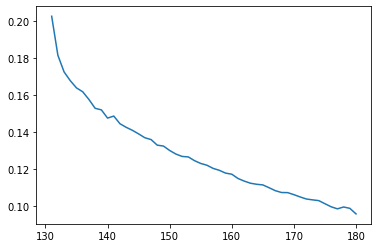

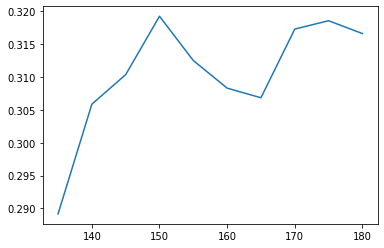

In [27]:
plt.plot(list(loss_hist.keys()), list(loss_hist.values()))
plt.show()

plt.plot(list(val_hist.keys()), list(val_hist.values()))
plt.show()

In [28]:
val_hist

{135: 0.28916015625,
 140: 0.305859375,
 145: 0.3103515625,
 150: 0.31923828125,
 155: 0.3125,
 160: 0.30830078125,
 165: 0.3068359375,
 170: 0.31728515625,
 175: 0.3185546875,
 180: 0.3166015625}

# Validatoin and Testing

In [29]:
last_ckp = PATH_CKPTS + "11_encoder_128-150" # tf.train.latest_checkpoint(PATH_CKPTS)
start_epoch = 0

if last_ckp:
    ckpt = tf.train.Checkpoint(optimizer=optimizer, SIAMESE=SIAMESE)
    ckpt.restore(last_ckp)
    start_epoch = int(last_ckp.split("-")[-1])

print(f'Resume training from epoch {start_epoch}') 

Resume training from epoch 150


In [30]:
val_pred = test(ds_valid)

In [45]:
COSINE_THRE = 0.81

In [46]:
val_pred_thres = cut_thres(val_pred, 0.81)
val_acc = cal_acc(val_ans, val_pred_thres)
print("Validation Acc: ", val_acc)

Validation Acc:  0.32158203125


In [47]:
te_pred = test(ds_test)

In [48]:
te_pred_thres = cut_thres(te_pred, COSINE_THRE)
output_df = output(te_pred_thres)

In [49]:
output_df.to_csv("../output/{}_{}.csv".format(checkpoint_name, start_epoch), index=False)